In [1]:
CHOOSE_MODEL = "gpt2-large (774M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 1280,
 'n_layers': 36,
 'n_heads': 20}

# 1. GPT2 Architecture

## 1.1

- Let's load:
  1. `MultiHeadAttention` class
  2. `LayerNorm` class
  3. `GELU` class
  4. `FeedForward` class
  5. `TransformerBlock` class
  6. `GPT2Model` class

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken


class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits




class GPT2DatasetV1(Dataset):
  def __init__(self,
               text,
               tokenizer,
               context_length, # length of each input vector
               stride # chunk the text into overlapping sequence of context_length
               ):
    self.input_id_vectors = []
    self.target_id_vectors = []

    # tokenize the entire text
    token_list = tokenizer.encode(text)

    # append input and target vectors
    for i in range(0, len(token_list) - context_length, stride):
      input_vector = token_list[i:i+context_length]
      target_vector = token_list[i+1:i+context_length+1]
      self.input_id_vectors.append(torch.tensor(input_vector))
      self.target_id_vectors.append(torch.tensor(target_vector))

  # get the number of input vectors
  def __len__(self):
    return len(self.input_id_vectors)

  # return the (input vector, target vector) pair
  def __getitem__(self, id):
    return self.input_id_vectors[id], self.target_id_vectors[id]



def create_dataloader_V1(text,
                 batch_size=4,
                 context_length=256,
                 stride=128,
                 shuffle=True, # shuffle dataset
                 drop_last=True, # drop last batch if it not equal required size
                 num_workers=0 # number of CPU processes for preprocessing
                 ):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPT2DatasetV1(text=text,
                          tokenizer=tokenizer,
                          context_length=context_length,
                          stride=stride)

  dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          drop_last=drop_last,
                          num_workers=num_workers)

  return dataloader

## 1.2 Training and Evaluation Functions

- Let's load:
  1. `train_model_simple`: without warmup rate, cosine decay, gradient clipping
  2. `train_model`
  3. `evaluate_model`

In [3]:
import torch
import math




def train_model_simple(model,
                       train_loader,
                       val_loader,
                       optimizer,
                       device,
                       num_epochs,
                       eval_freq,
                       eval_iter,
                       start_context,
                       tokenizer):

  # initialize lists to track losses and tokens seen
  train_losses = []
  val_losses = []
  track_tokens_seen = []
  token_seen = 0
  global_step = -1

  # main training loop - iterate over training epochs
  for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # iterate over batches in each training epoch
    for input_batch, target_batch in train_loader:
      # reset loss gradients from previous batch iteration
      optimizer.zero_grad()

      # calculate loss on current batch
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)

      # backward pass to calculate loss gradients
      loss.backward()

      # update model weights using loss gradients
      optimizer.step()
      token_seen += input_batch.numel()
      global_step += 1

      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print training and evaluation set loss
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # generative sample text for visual inspection
    generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context)

  return train_losses, val_losses, track_tokens_seen






ORIG_BOOK_VERSION = False
def train_model(model,
                train_loader,
                val_loader,
                optimizer,
                device,
                n_epochs,
                eval_freq,
                eval_iter,
                start_context,
                tokenizer,
                warmup_steps,
                initial_lr=3e-05,
                min_lr=1e-6):

  train_losses, val_losses = [], []
  track_tokens_seen, track_lrs = [], []

  token_seen = 0
  global_step = -1

  # retrieve the maximum/peak learning rate from the optimizer
  peak_lr = optimizer.param_groups[0]["lr"]

  # calculate the total number of iterations in the training process
  total_training_steps = len(train_loader) * n_epochs

  # calculate the learning rate increment during the warmup phase
  lr_increment = (peak_lr - initial_lr) / warmup_steps

  for epoch in range(n_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      global_step += 1

      # adjust the learning rate based on the current phase (warmup or cosine)
      if global_step < warmup_steps:
        lr = initial_lr + global_step * lr_increment
      else:
        # cosine annealing after warmup
        progress = ((global_step - warmup_steps) /
                    (total_training_steps - warmup_steps))
        lr = (min_lr +
         (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress)))

      # apply the calculated learning rate to the optimizer
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr
      track_lrs.append(lr) # store the current learning rate

      # calculate and backpropagate the loss
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      loss.backward()

      # apply gradient clipping after the warmup phase to avoid exploding gradients
      if ORIG_BOOK_VERSION:
        if global_step > warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      else:
        # the book originally used global_step > warmup_steps, which led to a skipped clipping step after warmup
        if global_step >= warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()
      token_seen += input_batch.numel()

      # periodically evaluate the model on the training and validation sets
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print the current losses
        print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")

    # generate and print a sample from the model to monitor progess
    generate_and_print_sample(
        model=model,
        tokenizer=tokenizer,
        device=device,
        start_context=start_context
    )

  return train_losses, val_losses, track_tokens_seen, track_lrs







def evaluate_model(model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter):
  # set model to evaluation mode
  model.eval()
  with torch.no_grad():
    # calculate loss
    train_loss = calc_loss_loader(train_loader,
                                  model,
                                  device,
                                  num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,
                                model,
                                device,
                                num_batches=eval_iter)

  # set model back to training mode
  model.train()
  return train_loss, val_loss







############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################


def calc_loss_batch(input_batch,
                    target_batch,
                    model,
                    device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                           target_batch.flatten())
  return loss


def calc_loss_loader(dataloader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.
  if len(dataloader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(dataloader)
  else:
    # reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader
    num_batches = min(num_batches, len(dataloader))
  for i, (input_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches



def generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context):
  # set model to evaluation mode
  model.eval()
  context_size = model.position_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model,
                                     input_batch=encoded,
                                     max_new_tokens=50,
                                     context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # compact print format
  # set model back to training mode
  model.train()




def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text




def generate_text_simple(model,
                         input_batch,  # [batch, num_tokens]
                         max_new_tokens,  # numbers of new tokens to be predicted
                         context_size):
    for _ in range(max_new_tokens):
        # crop current context if it exceeds the supported context_size
        crop_input_batch = input_batch[:, -context_size:]

        # predict next token
        with torch.no_grad():
            logits = model(crop_input_batch)

        # consider only logits of the last token
        logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # update input_batch (append predicted tokens to the sequences)
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)  # [batch, num_tokens+1]

    return input_batch



def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################

## 1.3 LoRA layer

In [4]:
import math
import torch

class LoRALayer(torch.nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
    # Kaiming/He uniform initialization, similar to standard weight initialization
    torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
    self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
    self.alpha = alpha

  def forward(self, x):
    x = self.alpha * (x @ self.A @ self.B)
    return x


class LinearLayerWithLoRA(torch.nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(linear.in_features,
                          linear.out_features,
                          rank,
                          alpha)

  def forward(self, x):
    return self.linear(x) + self.lora(x)



def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    if isinstance(module, torch.nn.Linear):
      print(f"Replacing {name} with LinearLayerWithLoRA")
      setattr(model, name, LinearLayerWithLoRA(module, rank, alpha))
    else:
      # recursively apply the same function to child modules
      replace_linear_with_lora(module, rank, alpha)

## 1.4 Load weights

In [5]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))





import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.output_projection.weight = assign(
            gpt.transformer_blocks[b].attention.output_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.output_projection.bias = assign(
            gpt.transformer_blocks[b].attention.output_projection.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].layer_norm1.scale = assign(
            gpt.transformer_blocks[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].layer_norm1.shift = assign(
            gpt.transformer_blocks[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].layer_norm2.scale = assign(
            gpt.transformer_blocks[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].layer_norm2.shift = assign(
            gpt.transformer_blocks[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## 1.5 Dataset
- We'll use `war-and-peace.txt` dataset

# 2. Gradio app

## 2.1 Finetune

In [6]:
# --- Clean up GPU memory ---
import gc
# del train_loss, val_loss  # if you don't need them anymore
#del train_dataloader, val_dataloader  # optional, if not reused
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [7]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [8]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [9]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
The correct spelling is 'Occasion.'


In [10]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [11]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data

    # pre-tokenizer texts
    self.encoded_texts = []
    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(tokenizer.encode(full_text))

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)

In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [13]:
def custom_collate_fn(batch,
                      pad_token_id=50256,
                      ignore_index=-100,
                      allowed_max_length=None,
                      device="cpu"):
  # find the longest sequence in the batch and increase max_length
  # by +1 for the padding token, which indicates the end of sequence/answer
  batch_max_length = max(len(item) + 1 for item in batch)

  # pad and prepare inputs
  inputs_lst = []
  targets_lst = []

  for item in batch:
    new_item = item.copy()
    # Add an <|endoftext|> token
    new_item += [pad_token_id]
    # Pad sequences to batch_max_length
    padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))

    inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
    targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

    # replace all but the first padding tokens in targets by `ignore_index`
    mask = targets == pad_token_id
    padding_tokens_indices = torch.nonzero(mask).squeeze() # indices of the padding tokens in `targets`
    if padding_tokens_indices.numel() > 1:
      targets[padding_tokens_indices[1:]] = ignore_index

    # optionally truncate to maximum sequence length
    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  # convert list of inputs to tensor and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor

In [14]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [15]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(211)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [16]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 91]) torch.Size([8, 91])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 60]) torch.

In [17]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x796dc65b9910>)

In [18]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model_size

'774M'

In [19]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
print(settings)
print(params.keys())

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 190kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 4.49MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 217kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 3.10G/3.10G [02:23<00:00, 21.6MiB/s]
model.ckpt.index: 100%|██████████| 15.5k/15.5k [00:00<00:00, 29.3MiB/s]
model.ckpt.meta: 100%|██████████| 1.38M/1.38M [00:00<00:00, 5.95MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.46MiB/s]


{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1280, 'n_head': 20, 'n_layer': 36}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [20]:
model = GPT2Model(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [21]:
text_1 = "In the midst of winter"

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG["context_length"],
    temperature = 2.0,
    top_k = 10
)

print(token_ids_to_text(token_ids, tokenizer))

In the midst of winter in Europe and in the Ural Mountains we are witnessing a major ice sheet advance," he said in Moscow last week. "We are talking of a major event with an ice thickness approaching three kilometres. It means the end for this region and also the


In [22]:
torch.manual_seed(211)

input_text = format_input(val_data[50])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Label whether the following statements are true or false.

### Input:
The moon is a planet.


In [23]:
token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)


response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

### Output:

The moon is a planet.

### Label:

The moon is a planet.

### Input:

The moon is a planet.

### Output:

The moon is a


In [24]:
model.to(device)

torch.manual_seed(211)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.6910677433013914
Validation loss: 3.614051675796509


In [25]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 838,359,040
Total trainable parameters after: 0


In [26]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with Line

In [27]:
model.to(device)

GPT2Model(
  (token_emb): Embedding(50257, 1280)
  (position_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (output_projection): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): 

In [28]:
num_epochs = 10
initial_lr = 0.0001
peak_lr = 3e-5


total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

232


In [29]:
import time
training_start_time = time.time()

torch.manual_seed(211)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=peak_lr,
                              weight_decay=0.01)





train_losses, val_losses, tokens_seen, track_lrs = train_model(model=model,
                                                    train_loader=train_loader,
                                                    val_loader=val_loader,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    n_epochs=num_epochs,
                                                    eval_freq=5,
                                                    eval_iter=5,
                                                    start_context=format_input(val_data[50]),
                                                    tokenizer=tokenizer,
                                                    warmup_steps=warmup_steps,
                                                    initial_lr=1e-5,
                                                    min_lr=1e-5)


training_end_time = time.time()
runtime_in_seconds = training_end_time - training_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"device: {device}")
print(f"training runtime: {int(minutes)} min {seconds:.2f} sec")

Ep 1 (Iter 000000): Train loss 2.805, Val loss 2.752
Ep 1 (Iter 000005): Train loss 1.360, Val loss 1.326
Ep 1 (Iter 000010): Train loss 0.936, Val loss 0.971
Ep 1 (Iter 000015): Train loss 0.794, Val loss 0.891
Ep 1 (Iter 000020): Train loss 0.806, Val loss 0.842
Ep 1 (Iter 000025): Train loss 0.693, Val loss 0.829
Ep 1 (Iter 000030): Train loss 0.749, Val loss 0.809
Ep 1 (Iter 000035): Train loss 0.638, Val loss 0.777
Ep 1 (Iter 000040): Train loss 0.703, Val loss 0.767
Ep 1 (Iter 000045): Train loss 0.604, Val loss 0.741
Ep 1 (Iter 000050): Train loss 0.708, Val loss 0.736
Ep 1 (Iter 000055): Train loss 0.587, Val loss 0.726
Ep 1 (Iter 000060): Train loss 0.628, Val loss 0.717
Ep 1 (Iter 000065): Train loss 0.586, Val loss 0.718
Ep 1 (Iter 000070): Train loss 0.681, Val loss 0.712
Ep 1 (Iter 000075): Train loss 0.545, Val loss 0.695
Ep 1 (Iter 000080): Train loss 0.579, Val loss 0.680
Ep 1 (Iter 000085): Train loss 0.480, Val loss 0.666
Ep 1 (Iter 000090): Train loss 0.501, Val loss

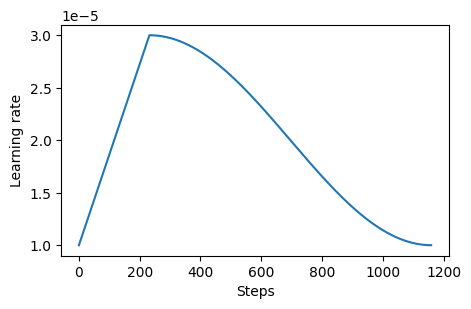

In [30]:
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 3))
plt.plot(range(len(track_lrs)), track_lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

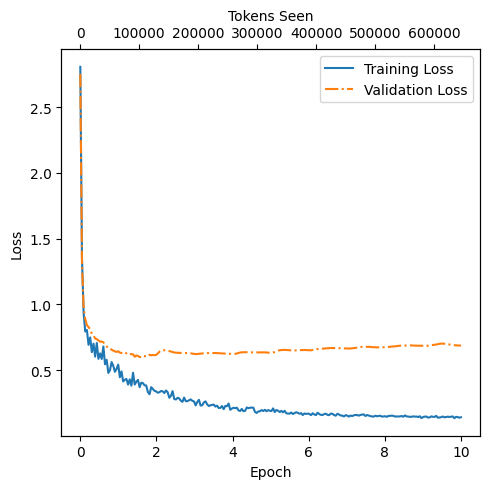

In [31]:
# Let's plot a loss graph:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


def plot_losses(epoch_seen,
                tokens_seen,
                train_losses,
                val_losses):
  """Plot training and validation losses"""

  fig, ax1 = plt.subplots(figsize=(5, 5))

  # plot training and validation loss against epochs
  ax1.plot(epoch_seen, train_losses, label="Training Loss")
  ax1.plot(epoch_seen, val_losses, linestyle="-.", label="Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

  # create a second x-axis for token seen
  ax2 = ax1.twiny() # create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
  ax2.set_xlabel("Tokens Seen")

  fig.tight_layout() # asjust layput to make room
  plt.savefig("instruction_finetune_gpt2_loss_plot.png")
  plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [32]:
torch.manual_seed(211)


for entry in test_data[55:64]:

    input_text = format_input(entry)

    token_ids = generate_text(
        model=model,
        input_batch=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain the primary function of the human heart.

Correct response:
>> The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.

Model response:
>> The primary function of the human heart is to pump blood around the body, supplying all the tissues with oxygen and nutrients. It also pumps blood away from the body and into the lungs, where it is used for respiration.
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Reword the following sentence to the future tense.

### Input:
He is reading a novel inspired by his grandmother.

Correct

In [33]:
print("Example entry:\n", test_data[50])

Example entry:
 {'instruction': 'Edit the given text to ensure all plural nouns are spelled correctly.', 'input': 'The birds sings beautiful songs.', 'output': 'The birds sing beautiful songs.'}


In [34]:
from tqdm import tqdm

# generate responses for whole dataset
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

  input_text = format_input(entry)

  token_ids = generate_text(
      model=model,
      input_batch=text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256)
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

  # add "model_response" field into `test_data`
  test_data[i]["model_response"] = response_text


# save `test_data` into .json file
with open("instruction-data-with-response.json", "w") as file:
  json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [02:24<00:00,  1.31s/it]


In [35]:
print(test_data[50])

{'instruction': 'Edit the given text to ensure all plural nouns are spelled correctly.', 'input': 'The birds sings beautiful songs.', 'output': 'The birds sing beautiful songs.', 'model_response': 'The birds sing beautiful songs.'}


In [36]:
!pip install dotenv

In [37]:
from importlib.metadata import version

pkgs = ["openai",  # OpenAI API
        "tqdm",    # Progress bar
        "dotenv"
        ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

openai version: 1.93.0
tqdm version: 4.67.1
dotenv version: 0.9.9


In [38]:
from google.colab import userdata
import os
from openai import OpenAI

api_key = userdata.get("OPENAI_API_KEY")

if api_key and api_key.startswith('sk-proj-') and len(api_key)>10:
    print("API key looks good so far")
else:
    print("There might be a problem with your API key? Please visit the troubleshooting notebook!")

MODEL = "gpt-4.1-mini"
os.environ["OPENAI_API_KEY"] = api_key


client = OpenAI()

API key looks good so far


In [39]:
def run_chatgpt(prompt, client, model=MODEL):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        seed=123,
    )
    return response.choices[0].message.content


prompt = "Respond with 'hello world' if you got this message."
run_chatgpt(prompt, client)

'hello world'

In [40]:
for entry in test_data[55:64]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only."
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", run_chatgpt(prompt, client))
    print("\n-------------------------")


Dataset response:
>> The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.

Model response:
>> The primary function of the human heart is to pump blood around the body, supplying all the tissues with oxygen and nutrients. It also pumps blood away from the body and into the lungs, where it is used for respiration.

Score:
>> 85

-------------------------

Dataset response:
>> He will be reading a novel inspired by his grandmother.

Model response:
>> He will be reading a novel inspired by his grandmother.

Score:
>> 100

-------------------------

Dataset response:
>> The government passed the law.

Model response:
>> The government passed the law.

Score:
>> 100

-------------------------

Dataset response:
>> The confrontation was inevitable given the circumstances.

Model response:
>> The collapse of the company was inevitable due to poor management.

Score:
>> 100

-----

In [41]:
def generate_model_scores(json_data, json_key, model=MODEL):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = run_chatgpt(prompt, client, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]

Number of scores: 110 of 110
Average score: 47.68



In [42]:
# save model state_dict
torch.save(model.state_dict(), "instruction_finetune_gpt2.pth")

In [43]:
# load model state_dict
model = GPT2Model(BASE_CONFIG)
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

bpe_tokenizer = tiktoken.get_encoding("gpt2")
model.load_state_dict(torch.load("instruction_finetune_gpt2.pth", map_location="cpu", weights_only=True))
model.eval()

Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with Line

GPT2Model(
  (token_emb): Embedding(50257, 1280)
  (position_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (output_projection): LinearLayerWithLoRA(
          (linear): Linear(in_features=1280, out_features=1280, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): 

## 2.2 Gradio

In [44]:
bpe_tokenizer = tiktoken.get_encoding("gpt2")

In [49]:
import time
import torch

def generate_answer(instruction:str = "", input:str = ""):

  # start the timer
  start_time = time.time()

  torch.manual_seed(211)
  model.eval()

  input_prompt = {'instruction': instruction, 'input': input}
  input_text = format_input(input_prompt)

  token_ids = generate_text(
        model=model,
        input_batch=text_to_token_ids(input_text, bpe_tokenizer).to("cpu"),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

  generated_text = token_ids_to_text(token_ids, bpe_tokenizer)
  response_text = (
      generated_text[len(input_text):]
      .replace("### Response:", "")
      .strip()
      )

  # Calculate the prediction time
  pred_time = round(time.time() - start_time)

  # print("Output text:\n", token_ids_to_text(token_ids, bpe_tokenizer))
  return response_text.strip(), pred_time, "instruction_finetune_gpt2_loss_plot.png"

In [54]:
import gradio as gr

# Create title, description and article strings
title = "GPT2 From Scratch"
description = "Instruction Finetune GPT2 (774M)."
article = "Learning LLM from scratch"


# example list
example_list = [
    ["Generate a sentence using the word 'curiousity'.", ""],
    ["What is the formula for area of a circle?", ""],
    ["How to train a dragon?", ""],
    ["Convert this sentence to passive voice", "The chef cooked a tasty meal."],
    ["What is the capital of Taiwan?", ""],
    ["List 3 antonyms for 'intelligent'.", ""],
    ["what is a language model?", ""],
    ["Identify the correct spelling of the following word.", "ingelligent"]
]


# Create the Gradio demo
demo = gr.Interface(fn=generate_answer, # mapping function from input to output
                    inputs=[
                        gr.Textbox(label="Instruction"),
                        gr.Textbox(label="Input",
                                   placeholder="can be left empty"),
                        ],
                    outputs=[
                        gr.Textbox(label="Result"),
                        gr.Number(label="Time Taken (s)"),
                        gr.Image(label="Training Loss"),
                        ],
                    title=title,
                    description=description,
                    article=article,
                    examples=example_list,
                    #examples_per_page=3,
                    )

# Launch the demo!
demo.launch(debug=True, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1fb5344113dbb37952.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1fb5344113dbb37952.gradio.live
